# Importing modules

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imageio import imread

import re, nltk
nltk.download('stopwords') # you can run this in terminal
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from functools import lru_cache # for caching lemmatization results to help save time

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the Data

In [49]:
df = pd.read_csv('./uncommitted/Hotel_Reviews.csv')
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


Since we have duplicates hotel details from different reviewers who stayed at the same hotel, let's make a hotels dataset out of the original dataset so we can investigate each hotel later.

In [3]:
df_hotels = df[['Hotel_Address', 'Additional_Number_of_Scoring', 'Average_Score', 'Hotel_Name', 'Total_Number_of_Reviews', 'lat', 'lng']].drop_duplicates()
df_hotels.head()

,Hotel_Address,Additional_Number_of_Scoring,Average_Score,Hotel_Name,Total_Number_of_Reviews,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7.7,Hotel Arena,1403,52.360576,4.915968
405,1 15 Templeton Place Earl s Court Kensington a...,244,8.5,K K Hotel George,1831,51.491888,-0.194971
971,1 2 Serjeant s Inn Fleet Street City of London...,639,9.2,Apex Temple Court Hotel,2619,51.513734,-0.108751
2008,1 3 Queens Garden Westminster Borough London W...,1058,7.7,The Park Grand London Paddington,4380,51.514218,-0.180903
3778,1 3 Rue d Argentine 16th arr 75116 Paris France,26,8.4,Monhotel Lounge SPA,171,48.874348,2.289733


In [4]:
df_hotels.shape

(1494, 7)

Now let's go back to the original dataset and explore around

In [5]:
df.shape

(515738, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

We can see that the dataset for the most part does not contain missing values except for latitude and longitude values.

In [7]:
df.describe(include='all')

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
count,515738,515738.000000,515738,515738.000000,515738,515738,515738,515738.000000,515738.000000,515738,515738.000000,515738.000000,515738.000000,515738,515738,512470.000000,512470.000000
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,NaN,55242,731,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN
freq,4789,NaN,2585,NaN,4789,245246,127890,NaN,NaN,35946,NaN,NaN,NaN,5101,2585,NaN,NaN
mean,NaN,498.081836,NaN,8.397487,NaN,NaN,NaN,18.539450,2743.743944,NaN,17.776458,7.166001,8.395077,NaN,NaN,49.442439,2.823803
std,NaN,500.538467,NaN,0.548048,NaN,NaN,NaN,29.690831,2317.464868,NaN,21.804185,11.040228,1.637856,NaN,NaN,3.466325,4.579425
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,2.500000,NaN,NaN,41.328376,-0.369758
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,7.500000,NaN,NaN,48.214662,-0.143372
50%,NaN,341.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,8.800000,NaN,NaN,51.499981,0.010607
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.000000,9.600000,NaN,NaN,51.516288,4.834443


We can observe a number of things:
- Britannia International Hotel Canary Wharf is the most frequent hotel in this dataset
- The mean of all hotels average scores is 8.4, and the interquartile range (i.e. between 25th and 75th percentiles) is 8.1-8.8
- The mean of all individual review scores is also 8.4 but the interquartile range is 7.5-9.6
- The most frequent nationality of reviewer is United Kingdom

# Sampling the Data

To speed up computation, we will sample a fraction of the original dataset.

In [8]:
df = df.sample(frac=0.2, replace = False, random_state=14)
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
250306,8 rue Chambiges 8th arr 75008 Paris France,122,8/11/2015,8.9,Chambiges Elys es,United Kingdom,There were bed bugs Nasty,7,858,No Positive,0,6,3.8,"[' Leisure trip ', ' Couple ', ' 2 rooms ', ' ...",723 day,48.866805,2.303946
358387,Kirchberggasse 6 07 Neubau 1070 Vienna Austria,285,2/25/2017,8.7,K K Hotel Maria Theresia,United Kingdom,Walls are pretty thin so could hear folk in t...,17,3181,Room was very clean and the bed was extremely...,36,2,9.6,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",159 day,48.203162,16.356200
351102,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,2/18/2017,8.3,Mercure Josefshof Wien,Switzerland,Room on the attic with window in the roof fel...,31,2526,Accessible to the metro and therefore easy ac...,14,17,6.3,"[' Business trip ', ' Solo traveler ', ' Class...",166 day,48.208563,16.354169
286546,Bergara 8 Eixample 08002 Barcelona Spain,256,9/27/2016,8.8,Hotel Pulitzer,Kuwait,not much entertainment in room we were only s...,31,1746,location was excellent staff were very helpfu...,21,1,7.9,"[' Leisure trip ', ' Couple ', ' Double or Twi...",310 day,41.386136,2.168291
485631,Via Pietro Gaggia 3 Ripamonti Corvetto 20139 M...,269,7/17/2016,8.1,Starhotels Business Palace,United Arab Emirates,No swimming pool,5,5265,Location Room size Cleaneanse,5,31,9.6,"[' Leisure trip ', ' Family with young childre...",382 day,45.437840,9.230901


In [9]:
df.shape

(103148, 17)

# Preprocessing

Add encoding columns for reviews that has the corresponding tags.

In [10]:
df['Leisure'] = df['Tags'].map(lambda x: 1 if ' Leisure trip ' in x else 0)
df['Business'] = df['Tags'].map(lambda x: 2 if ' Business trip ' in x else 0)
df['Trip_type'] = df['Leisure'] + df['Business']
df[100:105]

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Leisure,Business,Trip_type
335689,Guillem Tell 49 Sarri St Gervasi 08006 Barcelo...,190,7/3/2016,8.8,Pol Grace Hotel,Italy,Breakfast too expensive 10 euros per person O...,48,2220,Coffee and water for free almost 24h 7 If you...,49,18,8.8,"[' Business trip ', ' Group ', ' Double or Twi...",396 day,41.401747,2.147737,0,2,2
237877,7 Pepys Street City of London London EC3N 4AF ...,1936,1/30/2017,8.7,DoubleTree by Hilton Hotel London Tower of London,United Kingdom,Extortionate price of breakfast,5,7491,Warm cookies at check in comfortable rooms he...,10,2,9.6,"[' Leisure trip ', ' Group ', ' Queen Room ', ...",185 day,51.510841,-0.078058,1,0,1
464586,Taborstra e 12 02 Leopoldstadt 1020 Vienna Aus...,404,7/24/2016,9.1,Hotel Stefanie,Austria,No Negative,0,3883,Despite being in the city centre the hotel is...,33,7,10.0,"[' Leisure trip ', ' Couple ', ' Superior Doub...",375 day,48.214277,16.380178,1,0,1
468471,Uraniastra e 2 01 Innere Stadt 1010 Vienna Aus...,169,7/2/2017,8.1,Aparthotel Adagio Vienna City,Saudi Arabia,Staff very cold and boring they called my fam...,19,1787,Very good location and excellent view of Danu...,21,17,7.5,"[' Leisure trip ', ' Couple ', ' One Bedroom A...",32 days,48.211084,16.383841,1,0,1
300281,Consell de Cent 498 500 Eixample 08013 Barcelo...,105,1/23/2016,8.3,Eurostars Monumental,Norway,Very old almost thorn towels No Wifi in the r...,35,1382,The staff was nice polite and helpful Locatio...,40,19,7.5,"[' Business trip ', ' Solo traveler ', ' Doubl...",558 day,41.400665,2.178709,0,2,2


Assign country to each row in both the reviews dataset and hotels dataset. We will investigate trends according to country of hotels.

In [11]:
country = df['Hotel_Address'].map(lambda x: x.split()[-1])
country = country.map(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
df['hotel_country'] = country

country = df_hotels['Hotel_Address'].map(lambda x: x.split()[-1])
country = country.map(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
df_hotels['hotel_country'] = country

In [12]:
df['hotel_country'].value_counts()

United Kingdom    52415
Spain             12005
France            11985
Netherlands       11385
Austria            7905
Italy              7453
Name: hotel_country, dtype: int64

In [13]:
df['hotel_country'].value_counts().index

Index(['United Kingdom', 'Spain', 'France', 'Netherlands', 'Austria', 'Italy'], dtype='object')

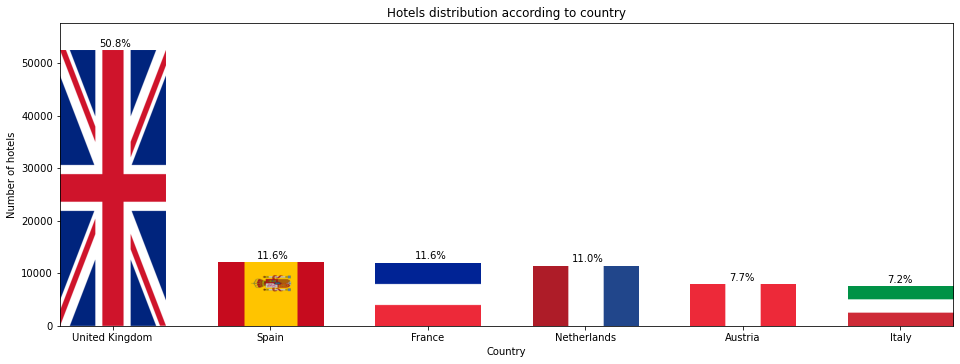

In [14]:
# Plot hotels distribution according to country
def image_plot(heights, images, spacing=0):
    # Iterate through images and data
    plt.figure(figsize=(16, 16))
    xticks_pos = []
    for i, (height, img) in enumerate(zip(heights, images)):
        width = img.shape[0] *20
        left = width*i + spacing*i
        right = left + width
        plt.imshow(img, extent=[left, right, 0, height])
        xticks_pos.append(left+10000) # for xticks position for country labels
        # Show percentage on top of bars
        percentage = height / len(df) * 100
        plt.text(left+7500, height+750, f"{round(percentage,1)}%")
    # Set x,y limits on plot window
    plt.xlim(0, right)
    plt.ylim(0, max(heights)*1.1)
    # Set xticks to country names, and set x, y labels and title
    plt.xticks(xticks_pos, df['hotel_country'].value_counts().index)
    plt.xlabel('Country')
    plt.ylabel('Number of hotels')
    plt.title('Hotels distribution according to country')

# Read in flag images
austria_flag = imread('austria-flag-medium.png').swapaxes(0, 1)
france_flag = imread('france-flag-medium.png').swapaxes(0, 1)
italy_flag = imread('italy-flag-medium.png').swapaxes(0, 1)
netherlands_flag = imread('netherlands-flag-medium.png').swapaxes(0, 1)
spain_flag = imread('spain-flag-medium.png').swapaxes(0, 1)
uk_flag = imread('united-kingdom-flag-medium.png').swapaxes(0, 1)

# Plot using image_plot
data = df['hotel_country'].value_counts()
flags = [uk_flag, spain_flag, france_flag, netherlands_flag, austria_flag, italy_flag]

image_plot(data, flags, spacing=10000)

In [15]:
# Average scores by country of hotels
df_hotels_mean = df_hotels.groupby(['hotel_country']).mean()
df_hotels_mean['Average_Score']

hotel_country
Austria           8.550000
France            8.493668
Italy             8.318519
Netherlands       8.409524
Spain             8.496209
United Kingdom    8.464000
Name: Average_Score, dtype: float64

Let's look at trends according to the nationality of reviewers.

In [16]:
# Reviewers' nationality
nationality_count = df['Reviewer_Nationality'].value_counts()

<ipython-input-17-c1488a952e27>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')
<ipython-input-17-c1488a952e27>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(nationality_count.index[-10:], rotation=45, ha='right')


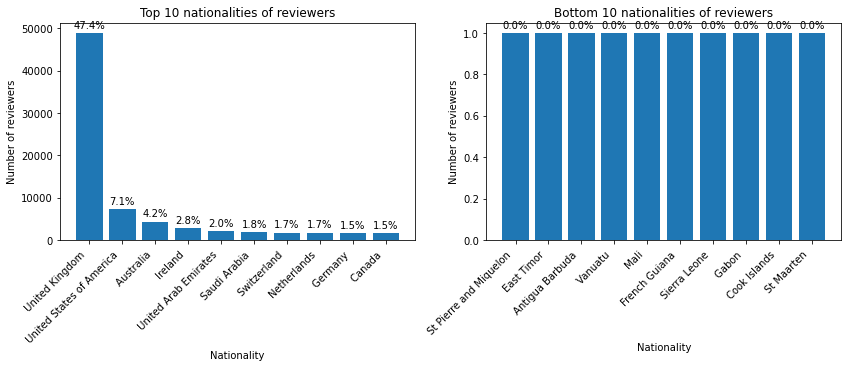

In [17]:
# Plot bar plots of top 10 nationalities and bottom 10 nationalities in the number of reviewers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
rects1 = ax[0].bar(nationality_count.index[:10], nationality_count[:10])
ax[0].set_title('Top 10 nationalities of reviewers')
ax[0].set_xlabel('Nationality')
ax[0].set_ylabel('Number of reviewers')
_ = ax[0].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')

rects2 = ax[1].bar(nationality_count.index[-10:], nationality_count[-10:])
ax[1].set_title('Bottom 10 nationalities of reviewers')
ax[1].set_xlabel('Nationality')
ax[1].set_ylabel('Number of reviewers')
_ = ax[1].set_xticklabels(nationality_count.index[-10:], rotation=45, ha='right')

def autolabel(rects, ax_i):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        # print(rect)
        height = rect.get_height()
        ax[ax_i].annotate(f"{round(height/len(df)*100, 1)}%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, 0)
autolabel(rects2, 1)

In [18]:
# Average scores according to reviewers' nationalities
nationality_score = df.groupby(['Reviewer_Nationality']).mean()
nationality_score = nationality_score['Reviewer_Score'].sort_values(ascending=False)
nationality_score

Reviewer_Nationality
 Crimea                       10.000000
 Guyana                       10.000000
 Vanuatu                      10.000000
 Samoa                        10.000000
 Sierra Leone                 10.000000
                                ...    
 Libya                         6.285714
 Seychelles                    6.242857
 Mongolia                      6.000000
 Northern Mariana Islands      5.800000
 Mali                          2.500000
Name: Reviewer_Score, Length: 194, dtype: float64

In [19]:
score_top_10_nationalities_in_no_reviewers = nationality_score[nationality_count.index[:10]]
score_top_10_nationalities_in_no_reviewers

 United Kingdom               8.483230
 United States of America     8.787942
 Australia                    8.563860
 Ireland                      8.508929
 United Arab Emirates         7.873124
 Saudi Arabia                 7.895796
 Switzerland                  8.189758
 Netherlands                  8.151547
 Germany                      8.101822
 Canada                       8.557935
Name: Reviewer_Score, dtype: float64

<ipython-input-20-d2f4ada50e6b>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(nationality_score.index[:10], rotation=45, ha='right')
<ipython-input-20-d2f4ada50e6b>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(nationality_score.index[-10:], rotation=45, ha='right')
<ipython-input-20-d2f4ada50e6b>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[2].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')


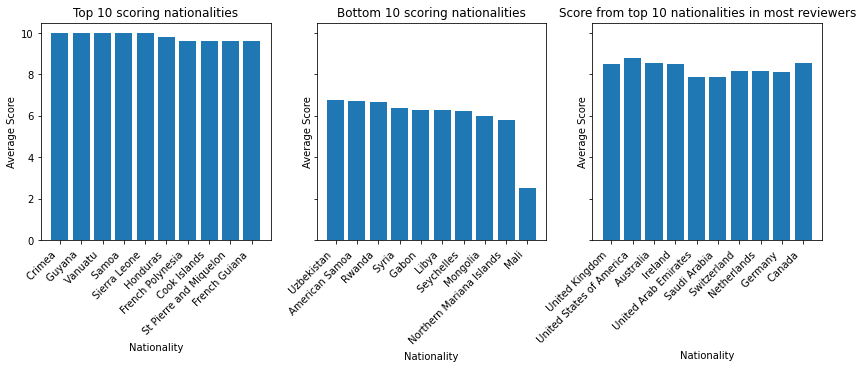

In [20]:
# Plot bar plots of top 10 nationalities and bottom 10 nationalities in the average reviewers score
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4), sharey=True)
rects1 = ax[0].bar(nationality_score.index[:10], nationality_score[:10])
ax[0].set_title('Top 10 scoring nationalities')
ax[0].set_xlabel('Nationality')
ax[0].set_ylabel('Average Score')
_ = ax[0].set_xticklabels(nationality_score.index[:10], rotation=45, ha='right')

rects2 = ax[1].bar(nationality_score.index[-10:], nationality_score[-10:])
ax[1].set_title('Bottom 10 scoring nationalities')
ax[1].set_xlabel('Nationality')
ax[1].set_ylabel('Average Score')
_ = ax[1].set_xticklabels(nationality_score.index[-10:], rotation=45, ha='right')

rects3 = ax[2].bar(nationality_count.index[:10], score_top_10_nationalities_in_no_reviewers)
ax[2].set_title('Score from top 10 nationalities in most reviewers')
ax[2].set_xlabel('Nationality')
ax[2].set_ylabel('Average Score')
_ = ax[2].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')


Bear in mind the nationalities in the top 10 and bottom 10 scoring bar charts are only one or two reviewers per nationality as they aren't major nationalities.

Let's look at trends according to month when reviews were given.

In [21]:
# Average values by months
df['Month'] = df['Review_Date'].map(lambda x: x.split('/')[0])
df_month_mean = df.groupby(['Month']).mean()
df_month_mean

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng,Leisure,Business,Trip_type
Month,,,,,,,,,,,,
1,518.546426,8.414063,18.423759,2775.653363,17.801855,7.284071,8.444418,49.795298,2.648212,0.817467,0.307313,1.124780
10,491.390361,8.380767,17.705231,2716.898584,16.357583,7.292371,8.252159,49.361331,2.889022,0.770672,0.399954,1.170626
11,519.135790,8.384641,17.284333,2780.570628,16.412276,7.780269,8.355255,49.566031,2.674807,0.758128,0.420964,1.179092
12,526.627258,8.393558,17.194518,2779.952634,16.122900,7.546419,8.417822,49.899398,2.807736,0.812050,0.318808,1.130858
2,530.081010,8.404550,18.392162,2776.554182,17.654129,7.292346,8.505431,49.857933,2.328826,0.772620,0.390584,1.163204
3,512.749270,8.389574,18.286131,2772.522506,17.955231,7.191727,8.497701,49.600713,2.589080,0.760584,0.417032,1.177616
4,504.064633,8.419413,18.857830,2758.772669,18.748622,7.143460,8.462393,49.411602,2.831152,0.806217,0.331496,1.137713
5,492.651819,8.394086,19.675343,2703.327706,18.826944,7.114027,8.371488,49.345717,2.806535,0.814637,0.315182,1.129819
6,479.382281,8.401465,19.576328,2706.915591,18.987443,6.765725,8.382549,49.242042,2.969271,0.819788,0.306011,1.125799


Text(0.5, 1.0, 'Average score by month')

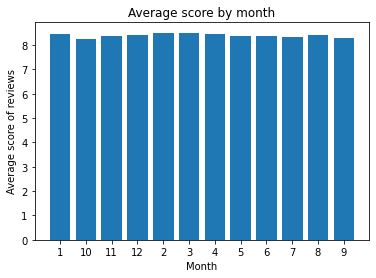

In [22]:
# Plot average score by month
plt.bar(df_month_mean.index, df_month_mean['Reviewer_Score'])
plt.xlabel('Month')
plt.ylabel('Average score of reviews')
plt.title('Average score by month')

And look at trends according to year.

In [23]:
# Average values by year
df['Year'] = df['Review_Date'].map(lambda x: x.split('/')[-1])
df_year_mean = df.groupby(['Year']).mean()
df_year_mean

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng,Leisure,Business,Trip_type
Year,,,,,,,,,,,,
2015,496.508684,8.374859,16.462701,2729.192143,15.883815,7.855985,8.322452,49.370071,2.919567,0.801737,0.338878,1.140615
2016,504.321829,8.404212,18.190487,2769.104707,17.575825,7.293627,8.425394,49.457769,2.802071,0.813385,0.317957,1.131342
2017,485.326172,8.404837,20.454911,2696.903293,19.175050,6.725799,8.381787,49.455718,2.838603,0.807358,0.322120,1.129478


In [24]:
df_year_mean.index

Index(['2015', '2016', '2017'], dtype='object', name='Year')

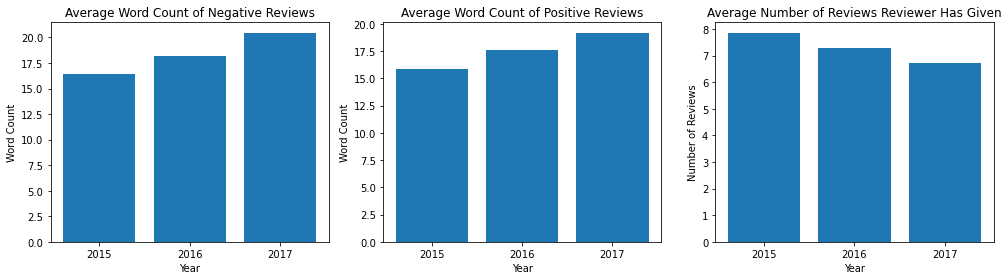

In [25]:
# Plot noticeable trends
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
ax[0].bar(df_year_mean.index, df_year_mean['Review_Total_Negative_Word_Counts'])
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Word Count')
ax[0].set_title('Average Word Count of Negative Reviews')
ax[1].bar(df_year_mean.index, df_year_mean['Review_Total_Positive_Word_Counts'])
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Word Count')
ax[1].set_title('Average Word Count of Positive Reviews')
ax[2].bar(df_year_mean.index, df_year_mean['Total_Number_of_Reviews_Reviewer_Has_Given'])
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Number of Reviews')
ax[2].set_title('Average Number of Reviews Reviewer Has Given')
fig.tight_layout()

After looking at months and years, only noticeable difference in review score with respect to date is from year 2015 to 2017:
- both negative word counts and positive word counts are increasing
- total number of reviews reviewer has given is decreasing

In [26]:
# Average score if certain words are mentioned e.g. air conditioning

In [27]:
myTuple = [""]

x = "#".join(myTuple)

print(x)


# Natural Language Processing

In [28]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
neg_reviews = []

# Function for lemmatization wrapped in lru_cache decorator for storing duplicate result in cache for faster computation
@lru_cache(maxsize=None) # Need to set maxsize=None otherwise it will default to 128
def perform_lemmatization(token):
    return lemmatizer.lemmatize(token)

# Perform NLP on all the negative reviews 
for review in df['Negative_Review']:
    review = review.lower()
    review = review.strip()
    if review in ['no negative', 'n a', 'nothing']:
        neg_reviews.append('')
        continue
    
    only_alphabets = re.sub("[^a-z]", " ", review)
    tokens = nltk.word_tokenize(only_alphabets)
    filtered_result = list(filter(lambda l: l not in stop_words, tokens))
    lemmas = [perform_lemmatization(t) for t in filtered_result]
    neg_reviews.append(' '.join(lemmas))

In [29]:
perform_lemmatization.cache_info()

CacheInfo(hits=866000, misses=23303, maxsize=None, currsize=23303)

In [30]:
neg_reviews[:5]

['bed bug nasty',
 'wall pretty thin could hear folk bathroom corridor',
 'room attic window roof felt closed coffee tea room restaurant hotel felt cold isolated',
 'much entertainment room served complementary water queen size bed bit big room perhaps use softer pillow',
 'swimming pool']

In [31]:
pos_reviews = []

# Perform NLP on all the positive reviews 
for review in df['Positive_Review']:
    review = review.lower()
    review = review.strip()
    if review in ['no positive', 'n a', 'nothing']:
        neg_reviews.append('')
        continue
    
    only_alphabets = re.sub("[^a-z]", " ", review)
    tokens = nltk.word_tokenize(only_alphabets)
    filtered_result = list(filter(lambda l: l not in stop_words, tokens))
    lemmas = [perform_lemmatization(t) for t in filtered_result]
    pos_reviews.append(' '.join(lemmas))

In [32]:
perform_lemmatization.cache_info()

CacheInfo(hits=1837230, misses=33370, maxsize=None, currsize=33370)

In [33]:
pos_reviews[:5]

['room clean bed extremely comfortable breakfast excellent restaurant option around min walk huge amount option would definitely stay',
 'accessible metro therefore easy access place interest',
 'location excellent staff helpful shower good effective room lighting loved lounge',
 'location room size cleaneanse',
 'shower breakfast okay expensive']

# Feature engineering

In [34]:
sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["Negative_Review"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
df

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,Leisure,Business,Trip_type,hotel_country,Month,Year,neg,neu,pos,compound
250306,8 rue Chambiges 8th arr 75008 Paris France,122,8/11/2015,8.9,Chambiges Elys es,United Kingdom,There were bed bugs Nasty,7,858,No Positive,...,1,0,1,France,8,2015,0.474,0.526,0.000,-0.5574
358387,Kirchberggasse 6 07 Neubau 1070 Vienna Austria,285,2/25/2017,8.7,K K Hotel Maria Theresia,United Kingdom,Walls are pretty thin so could hear folk in t...,17,3181,Room was very clean and the bed was extremely...,...,1,0,1,Austria,2,2017,0.000,0.814,0.186,0.4939
351102,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,2/18/2017,8.3,Mercure Josefshof Wien,Switzerland,Room on the attic with window in the roof fel...,31,2526,Accessible to the metro and therefore easy ac...,...,0,2,2,Austria,2,2017,0.205,0.795,0.000,-0.6908
286546,Bergara 8 Eixample 08002 Barcelona Spain,256,9/27/2016,8.8,Hotel Pulitzer,Kuwait,not much entertainment in room we were only s...,31,1746,location was excellent staff were very helpfu...,...,1,0,1,Spain,9,2016,0.080,0.920,0.000,-0.3252
485631,Via Pietro Gaggia 3 Ripamonti Corvetto 20139 M...,269,7/17/2016,8.1,Starhotels Business Palace,United Arab Emirates,No swimming pool,5,5265,Location Room size Cleaneanse,...,1,0,1,Italy,7,2016,0.524,0.476,0.000,-0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216091,58 Shepherds Bush Green Hammersmith and Fulham...,690,10/3/2016,8.6,Dorsett Shepherds Bush,Germany,Even though the room had all the needed facil...,49,2890,Perfect location close to central London Cons...,...,1,0,1,United Kingdom,10,2016,0.044,0.898,0.058,0.1779
493977,Viale Andrea Doria 4 Central Station 20124 Mil...,379,8/10/2016,8.9,Starhotels Echo,Italy,The hot water was not consistent,8,3774,Hotel and room was updated and comfortable,...,1,0,1,Italy,8,2016,0.000,1.000,0.000,0.0000
76495,18 Avenue De Suffren Entr e au 22 rue Jean Rey...,428,12/20/2016,8.6,Pullman Paris Tour Eiffel,Germany,Access to the closet was limited and made it ...,19,2764,Staff were helpful and polite view was great ...,...,1,0,1,France,12,2016,0.232,0.684,0.084,-0.4215
226958,64 76 Hendon Way London NW2 2NL United Kingdom,471,6/29/2017,7.9,Best Western Palm Hotel,United Kingdom,Private parking was advertised when I got the...,261,2037,After a long drive it was pretty close of the...,...,0,2,2,United Kingdom,6,2017,0.070,0.906,0.024,-0.7317


Scale continuous columns using RobustScaler.

In [35]:
scaler = RobustScaler()
columns_to_scale = ['Additional_Number_of_Scoring', 'Average_Score', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score']
scaled_columns = scaler.fit_transform(df[columns_to_scale])
scaled_columns = pd.DataFrame(scaled_columns, columns=columns_to_scale)

Perform one hot encoding on categorical columns.

In [36]:
ohe = OneHotEncoder(sparse=False)
columns_to_encode = ['hotel_country', 'Month', 'Year']
encoded_columns = ohe.fit_transform(df[columns_to_encode])
encoded_columns = pd.DataFrame(encoded_columns, columns=ohe.get_feature_names(['hotelcountry', 'month', 'year']))

We join both the transformed columns into one DataFrame.

In [37]:
df_transformed = pd.concat([scaled_columns, encoded_columns], axis=1)
df_transformed

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,hotelcountry_Austria,hotelcountry_France,hotelcountry_Italy,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,year_2015,year_2016,year_2017
0,-0.445122,0.714286,-0.090909,-0.518126,-0.647059,0.428571,-2.380952,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.113821,0.428571,0.363636,0.428106,1.470588,-0.142857,0.380952,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.231707,-0.142857,1.000000,0.161303,0.176471,2.000000,-1.190476,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.172764,0.571429,1.000000,-0.156415,0.588235,-0.285714,-0.428571,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.146341,-0.428571,-0.181818,1.276986,-0.352941,4.000000,0.380952,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103143,0.709350,0.285714,1.818182,0.309572,1.529412,0.571429,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103144,0.077236,0.714286,-0.045455,0.669654,-0.117647,-0.142857,0.571429,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
103145,0.176829,0.285714,0.454545,0.258248,0.294118,-0.285714,0.571429,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103146,0.264228,-0.714286,11.454545,-0.037882,0.058824,0.000000,-1.809524,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Add in the results from sentiment analysis and we will use this transformed dataframe for training our model later.

In [38]:
df[['neg','neu','pos','compound']]

,neg,neu,pos,compound
250306,0.474,0.526,0.000,-0.5574
358387,0.000,0.814,0.186,0.4939
351102,0.205,0.795,0.000,-0.6908
286546,0.080,0.920,0.000,-0.3252
485631,0.524,0.476,0.000,-0.2960
...,...,...,...,...
216091,0.044,0.898,0.058,0.1779
493977,0.000,1.000,0.000,0.0000
76495,0.232,0.684,0.084,-0.4215
226958,0.070,0.906,0.024,-0.7317


In [39]:
df_transformed = pd.concat([df_transformed, df[['neg','neu','pos','compound']].reset_index(drop=True)], axis=1)
df_transformed

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,hotelcountry_Austria,hotelcountry_France,hotelcountry_Italy,...,month_7,month_8,month_9,year_2015,year_2016,year_2017,neg,neu,pos,compound
0,-0.445122,0.714286,-0.090909,-0.518126,-0.647059,0.428571,-2.380952,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.474,0.526,0.000,-0.5574
1,-0.113821,0.428571,0.363636,0.428106,1.470588,-0.142857,0.380952,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.814,0.186,0.4939
2,-0.231707,-0.142857,1.000000,0.161303,0.176471,2.000000,-1.190476,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.205,0.795,0.000,-0.6908
3,-0.172764,0.571429,1.000000,-0.156415,0.588235,-0.285714,-0.428571,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.080,0.920,0.000,-0.3252
4,-0.146341,-0.428571,-0.181818,1.276986,-0.352941,4.000000,0.380952,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.524,0.476,0.000,-0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103143,0.709350,0.285714,1.818182,0.309572,1.529412,0.571429,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.044,0.898,0.058,0.1779
103144,0.077236,0.714286,-0.045455,0.669654,-0.117647,-0.142857,0.571429,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.000,1.000,0.000,0.0000
103145,0.176829,0.285714,0.454545,0.258248,0.294118,-0.285714,0.571429,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.232,0.684,0.084,-0.4215
103146,0.264228,-0.714286,11.454545,-0.037882,0.058824,0.000000,-1.809524,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.070,0.906,0.024,-0.7317


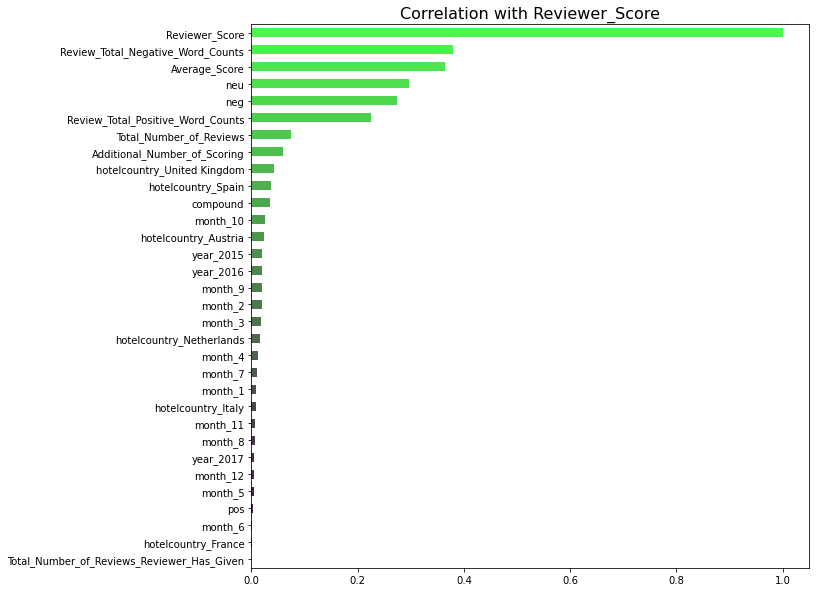

In [40]:
df_corr = df_transformed.corr()

# Get the colors for the graphic
colors = []
dim = df_corr.shape[0]
for i in range(dim):
    r = i * 1/dim
    colors.append((0.3,r,0.3))

# Transform each value in a positive value, because what interests us isn't the direction of the correlation but the absolute correlation
plt.figure(figsize=(10,10))
df_corr["Reviewer_Score"].apply(lambda x: abs(x)).sort_values().plot.barh(color = colors)

plt.title("Correlation with Reviewer_Score", fontsize = 16)
plt.show()


C:\Users\yapcm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\yapcm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


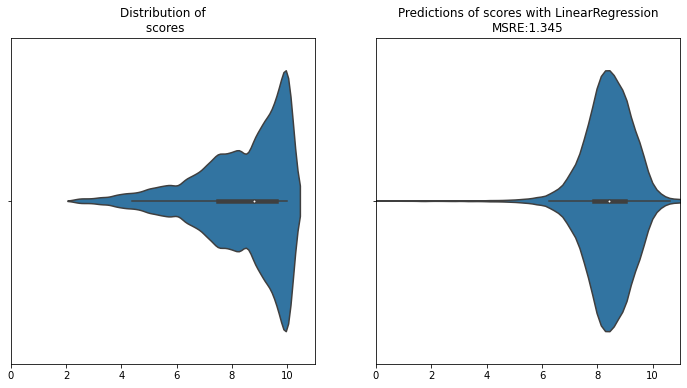

C:\Users\yapcm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\yapcm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


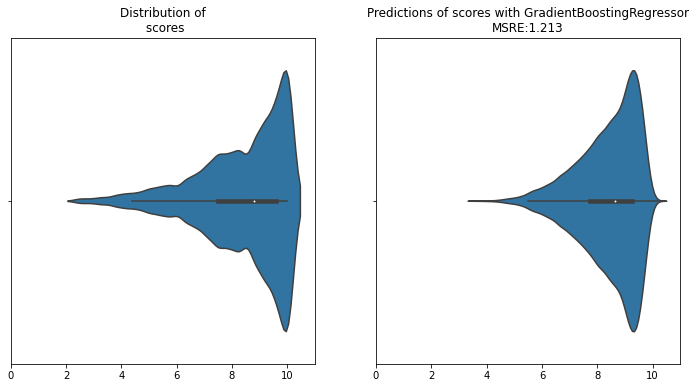

C:\Users\yapcm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\yapcm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


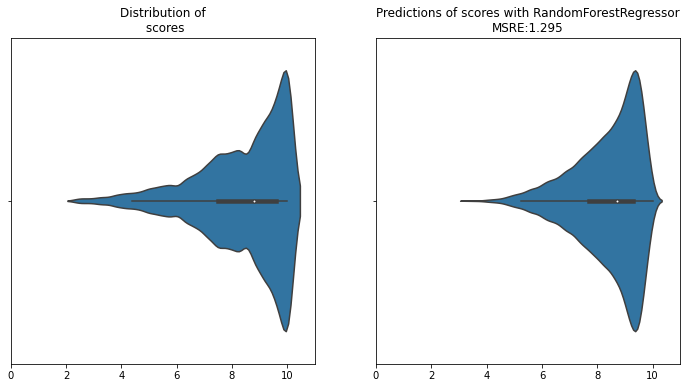

In [45]:

# Columns to use to train the models
# Only the columns with the highest correlation were chosen
cols = ['Review_Total_Negative_Word_Counts',
        'Average_Score',
        'neu',
        'neg',
        'Review_Total_Positive_Word_Counts']
        
X = df[cols].values
y = df["Reviewer_Score"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.metrics import mean_squared_error

def plot_res(y_test,pred, model = "LinearRegression"):
# Violinplots with the distribution of real scores and predicted scores

    MSRE = round((mean_squared_error(y_test,pred))**0.5,3)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
    
    sns.violinplot(y_test, ax = axes[0])
    axes[0].set_title("Distribution of\n scores")
    axes[0].set_xlim(0,11)
    
    sns.violinplot(pred, ax = axes[1])
    title = f"Predictions of scores with {model}\nMSRE:{MSRE}"
    axes[1].set_title(title)
    axes[1].set_xlim(0,11)
    plt.show()
    
# LinearRegression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "LinearRegression")

# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "GradientBoostingRegressor")

# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "RandomForestRegressor")